In [13]:
%run algebra.py
%run cache.py
%run costs.py
%run features.py
%run gradients.py
%run helpers.py
%run model.py
%run models.py
%run splits.py

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [14]:
SUB_SAMPLE = True
OUTPUT_DIR = "results_test/" if SUB_SAMPLE else "results/"

In [15]:
def load_csv_data(data_path, sub_sample=True):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids

In [16]:
y, x, ids = load_csv_data('data/train.csv', SUB_SAMPLE)

# 1 - Only Using Clean Features

In [6]:
def plot_heatmap(res, hs, value, x, y):
    val = np.vectorize(lambda x: x[value])(res)
    
    index = 0
    
    for key in sorted(hs.keys()):
        if key == x or key == y:
            index = index + 1
        else:
            val = np.apply_along_axis(np.mean, index, val)        
    
    ax = plt.imshow(1 / val, cmap='hot', interpolation='none')
    plt.show()

def find_arg_min(res, value):
    val = np.vectorize(lambda x: x[value])(res)
    index = np.where(val == val.min())

    print(res[tuple([i[0] for i in index])])

### Ridge Regression with Fixed Degree

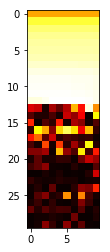

{'degree': 12.0, 'lambda': 2.1544346900318823e-05, 'mse': 0.27156314426523304}

In [8]:
myModel = RidgeRegression_MSE_Degree_Model(x, y)

res = myModel.evaluate(hs={ 
    'degree': np.arange(30), 
    'lambda': np.logspace(-8, -2, 10)
}, filename=OUTPUT_DIR+'RidgeRegression_MSE_Degree_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plt.imshow(1 / res_mse, cmap='hot', interpolation='nearest')
plt.show()

ii = np.where(res_mse == res_mse.min())
i, j = ii[0][0], ii[1][0]

res[i, j]

### Least Squares

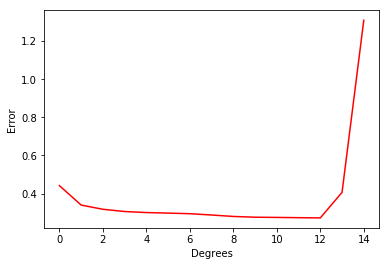

{'degree': 12.0, 'mse': 0.27188712714910396}

In [9]:
myModel = LeastSquare_MSE_Degree_Model(x, y)

degrees = np.arange(15)

hs={ 
    'degree': degrees
}

res = myModel.evaluate(hs, filename=OUTPUT_DIR+'LeastSquare_MSE_Degree_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plt.figure(2)
plt.plot(degrees, res_mse, 'r')
plt.xlabel('Degrees')
plt.ylabel('Error')
plt.show()

ii = np.where(res_mse == res_mse.min())
i = ii[0][0]

res[i]

### Stochastic Gradient Descent

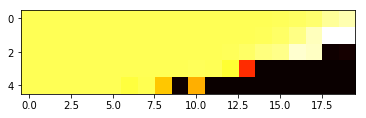

{'batch_size': 1.0, 'degree': 1.0, 'gamma': 0.01, 'n_iters': 100.0, 'mse': 0.4142108130994235}


In [20]:
myModel = StochasticGradientDescent_MSE_Degree_Model(x, y)

n_iters = 100
batch_size = 1
gammas = np.logspace(-10, -2, 20)
degrees = np.arange(5)

hs={
    'batch_size': batch_size,
    'n_iters': n_iters,
    'degree': degrees,
    'gamma': gammas
}

res = myModel.evaluate(hs, filename='results/SGD_Degree_Gamma_Variation_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plot_heatmap(res, hs, 'mse', 'degree', 'gamma')
find_arg_min(res, 'mse')

### Lasso SGD with Fixed Gamma 

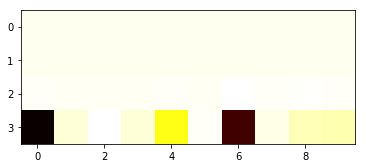

{'batch_size': 1.0, 'degree': 3.0, 'gamma': 1e-05, 'lambda': 2.1544346900318866e-09, 'n_iters': 100.0, 'mse': 0.49402108398968503}


In [28]:
myModel = Lasso_SGD_MSE_Degree_Model(x, y)

n_iters = 100
batch_size = 1
gamma = 10**-5
degrees = np.arange(4)
lambdas = np.logspace(-10, -4, 10)

hs={
    'n_iters': n_iters,
    'batch_size': batch_size,
    'gamma': gamma,
    'degree': degrees,
    'lambda': lambdas
}

res = myModel.evaluate(hs, filename=OUTPUT_DIR+'Lasso_SGD_Degree_Lambda_Variation_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plot_heatmap(res, hs, 'mse', 'degree', 'lambda')
find_arg_min(res, 'mse')

### Logistic Regression

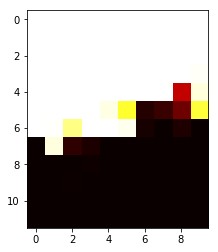

{'batch_size': 1.0, 'degree': 4.0, 'gamma': 2.1544346900318867e-07, 'n_iters': 10.0, 'mse': 0.4989238339106781}


In [7]:
myModel = First_Order_Logistic_Regression_Model(x, y)

n_iters = 10
batch_size = 1
degrees = np.arange(12)
gammas = np.logspace(-10, -5, 10)

hs={
    'n_iters': n_iters,
    'batch_size': batch_size,
    'degree': degrees,
    'gamma': gammas
}

res = myModel.evaluate(hs, filename=OUTPUT_DIR+'Logistic_Regression_Degree_Lambda_Variation_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plot_heatmap(res, hs, 'mse', 'degree', 'gamma')
find_arg_min(res, 'mse')

### Second Order Logistic Regression

LA TRONCHE DE TX DE BASE :
[[ 1.00000000e+00  3.96543618e-02  1.57246841e-03 ...  3.98182143e-01
   1.58549019e-01  6.31313883e-02]
 [ 1.00000000e+00  6.33440608e-01  4.01247004e-01 ... -2.31796107e-01
   5.37294352e-02 -1.24542739e-02]
 [ 1.00000000e+00 -6.41518864e-01  4.11546452e-01 ... -1.08298366e-01
   1.17285360e-02 -1.27018129e-03]
 ...
 [ 1.00000000e+00 -1.22366112e+00  1.49734654e+00 ...  2.34160770e-01
   5.48312663e-02  1.28393315e-02]
 [ 1.00000000e+00 -1.12174093e-01  1.25830271e-02 ... -4.11062512e-01
   1.68972389e-01 -6.94582148e-02]
 [ 1.00000000e+00 -1.31829705e+00  1.73790712e+00 ... -2.25396588e-01
   5.08036217e-02 -1.14509630e-02]]


Degrees: 3

new_iter 
(5000, 5000)
(5000, 58)
(58, 58)
(58,)

new_iter 
(5000, 5000)
(5000, 58)
(58, 58)
(58,)

new_iter 
(5000, 5000)
(5000, 58)
(58, 58)
(58,)

new_iter 
(5000, 5000)
(5000, 58)
(58, 58)
(58,)

new_iter 
(5000, 5000)
(5000, 58)
(58, 58)
(58,)

new_iter 
(5000, 5000)
(5000, 58)
(58, 58)
(58,)

new_iter 
(5000, 5000)


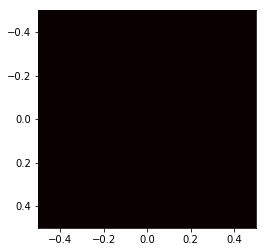

{'batch_size': 1, 'degree': 3, 'gamma': 1e-10, 'n_iters': 10, 'mse': 0.4999999977579344}


In [8]:
myModel = Second_Order_Logistic_Regression_Model(x, y)

n_iters = 10
batch_size = 1
degrees = 3
gammas = 10**-10

hs={
    'n_iters': n_iters,
    'batch_size': batch_size,
    'degree': degrees,
    'gamma': gammas
}

res = myModel.evaluate(hs, filename=OUTPUT_DIR+'SecondOrd_Logistic_Regression_Degree_Lambda_Variation_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plot_heatmap(res, hs, 'mse', 'degree', 'gamma')
find_arg_min(res, 'mse')